   APPLICATION_ID APPLICATION_DT        PRODUCT COSIGNER_IND  \
0       536493688     2020-04-15         Parent            N   
1       346994805     2020-04-09  Undergraduate            Y   
2       319700874     2020-04-21  Undergraduate            Y   
3       573265936     2020-04-10       Graduate            N   

  ACQUISITION_CHANNEL PRODUCT_RATE_TYPE_DESC  PRODUCT_TERM_NUM  INTEREST_RT  \
0              Direct                  FIXED                10       0.1179   
1                 SEM                  FIXED                10       0.0798   
2                 SEM                  FIXED                10       0.0503   
3    Partner Referral               VARIABLE                15       0.1493   

   BORROWER_INCOME  BORROWER_LIABILITY  CREDIT_SCORE  REQUESTED_LOAN_AMT  \
0           139300                3370           715               30600   
1            99300                1990           794                7100   
2            52300                1830           834   

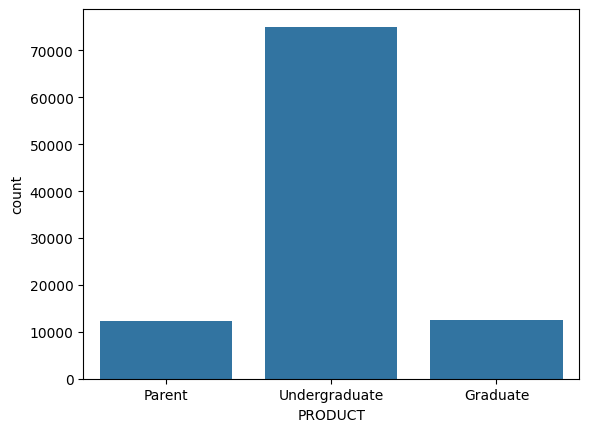

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel("C:/Users/Rajan/Downloads/USITCC_2024_FINAL_DATA.xlsx")

print(df.head(4))
print(df.columns.values.tolist())
print(df['CREDIT_SCORE'].mean())
print(df['INITIAL_APPROVAL_CNT'].mean())
print(df['BORROWER_INCOME'].describe())
print((df['BORROWER_INCOME'].quantile(0.75))-(df['BORROWER_INCOME'].quantile(0.25)))
print(df['INTEREST_RT'].corr(df['CREDIT_SCORE']))
sns.countplot(x = 'PRODUCT', data = df)
plt.show()

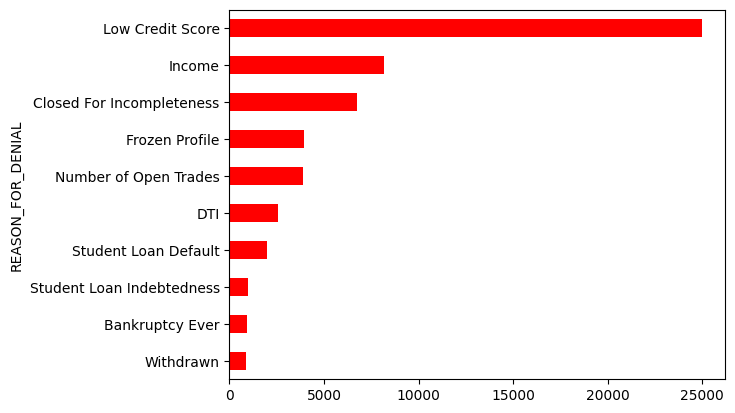

In [4]:
x = df['REASON_FOR_DENIAL'].value_counts(ascending = True)
x.plot(kind = 'barh', color = 'red')
plt.show()

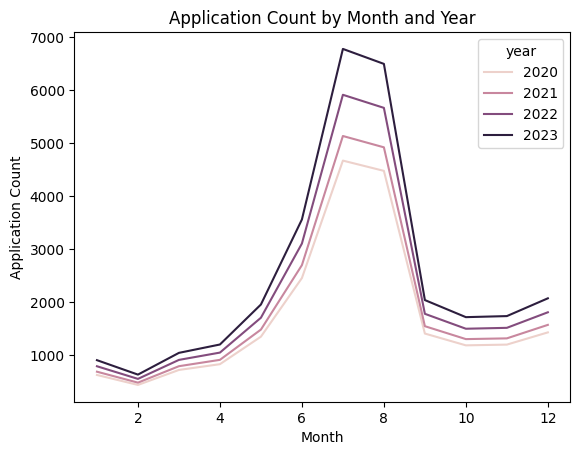

In [5]:
df['APPLICATION_DT'] = pd.to_datetime(df['APPLICATION_DT'])
df['year']= df['APPLICATION_DT'].dt.year
df['month'] = df['APPLICATION_DT'].dt.month
grouped = df.groupby(['year', 'month']).size().reset_index(name='count')

# Plot the data
sns.lineplot(x='month', y='count', hue='year', data=grouped)
plt.xlabel('Month')
plt.ylabel('Application Count')
plt.title('Application Count by Month and Year')
plt.show()

In [6]:
df['Borrower_mon_income'] = df['BORROWER_INCOME'] / 12
df['DTI'] = df['BORROWER_LIABILITY']/df['Borrower_mon_income']

In [7]:
from sklearn.preprocessing import StandardScaler
features = ['REQUESTED_LOAN_AMT', 'INTEREST_RT', 'BORROWER_INCOME', 'CREDIT_SCORE', 'DTI']
x = df[features]

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert the normalized features back to a DataFrame
df_normalized = pd.DataFrame(x_normalized, columns=features)

# Adding normalized columns to the original DataFrame
for feature in features:
    df[f'normalized_{feature}'] = df_normalized[feature]

print(df.head())

   APPLICATION_ID APPLICATION_DT        PRODUCT COSIGNER_IND  \
0       536493688     2020-04-15         Parent            N   
1       346994805     2020-04-09  Undergraduate            Y   
2       319700874     2020-04-21  Undergraduate            Y   
3       573265936     2020-04-10       Graduate            N   
4       484243366     2020-04-09  Undergraduate            N   

  ACQUISITION_CHANNEL PRODUCT_RATE_TYPE_DESC  PRODUCT_TERM_NUM  INTEREST_RT  \
0              Direct                  FIXED                10       0.1179   
1                 SEM                  FIXED                10       0.0798   
2                 SEM                  FIXED                10       0.0503   
3    Partner Referral               VARIABLE                15       0.1493   
4                 SEM                  FIXED                10       0.1526   

   BORROWER_INCOME  BORROWER_LIABILITY  ...  BOOKED_IND  year month  \
0           139300                3370  ...           Y  2020     4  

In [8]:
covariance_matrix = df_normalized.cov()

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                    REQUESTED_LOAN_AMT  INTEREST_RT  BORROWER_INCOME  \
REQUESTED_LOAN_AMT            1.000010    -0.000427         0.000459   
INTEREST_RT                  -0.000427     1.000010        -0.243628   
BORROWER_INCOME               0.000459    -0.243628         1.000010   
CREDIT_SCORE                 -0.000275    -0.869590         0.214199   
DTI                          -0.003703    -0.009136         0.000231   

                    CREDIT_SCORE       DTI  
REQUESTED_LOAN_AMT     -0.000275 -0.003703  
INTEREST_RT            -0.869590 -0.009136  
BORROWER_INCOME         0.214199  0.000231  
CREDIT_SCORE            1.000010  0.007269  
DTI                     0.007269  1.000010  


In [9]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_normalized)

# Convert the top three components to a DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df['PC1'] = df_pca['PC1']
df['PC2'] = df_pca['PC2']
df['PC3'] = df_pca['PC3']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df['BOOKED_IND'] = df['BOOKED_IND'].apply(lambda x: 1 if x == 'Y' else 0)

# Split the dataset into training (70%), validation (15%), and testing (15%) sets
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

x_train = train[['PC1', 'PC2', 'PC3']]
y_train = train['BOOKED_IND']
x_val = val[['PC1', 'PC2', 'PC3']]
y_val = val['BOOKED_IND']
x_test = test[['PC1', 'PC2', 'PC3']]
y_test = test['BOOKED_IND']
print("Training set class distribution:\n", y_train.value_counts())
print("Validation set class distribution:\n", y_val.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

Training set class distribution:
 BOOKED_IND
0    39841
1    30091
Name: count, dtype: int64
Validation set class distribution:
 BOOKED_IND
0    8518
1    6467
Name: count, dtype: int64
Test set class distribution:
 BOOKED_IND
0    8536
1    6450
Name: count, dtype: int64


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score

import statsmodels.api as sm

# Add a constant to the model (intercept)
x_train_const = sm.add_constant(x_train)

# Fit the model
logit_model = sm.Logit(y_train, x_train_const).fit()

# Print the summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.470942
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             BOOKED_IND   No. Observations:                69932
Model:                          Logit   Df Residuals:                    69928
Method:                           MLE   Df Model:                            3
Date:                Wed, 17 Jul 2024   Pseudo R-squ.:                  0.3109
Time:                        18:18:05   Log-Likelihood:                -32934.
converged:                       True   LL-Null:                       -47791.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4277      0.010    -43.561      0.000      -0.447      -0.408
PC1           -1.2149      0.

In [13]:
x_val_const = sm.add_constant(x_val)
x_test_const = sm.add_constant(x_test)

# Predict probabilities and classes for validation data
y_val_proba = logit_model.predict(x_val_const)
y_val_pred = (y_val_proba >= 0.5).astype(int)


val_precision = precision_score(y_val, y_val_pred, zero_division=0)
val_recall = recall_score(y_val, y_val_pred, zero_division=0)
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)


print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation MSE:", val_mse)
print("Validation MAE:", val_mae)



Validation Precision: 0.7198884148342632
Validation Recall: 0.678367094479666
Validation MSE: 0.2527193860527194
Validation MAE: 0.2527193860527194


In [14]:
y_test_proba = logit_model.predict(x_test_const)
y_test_pred = (y_test_proba >= 0.5).astype(int)


test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

Test Precision: 0.7158469945355191
Test Recall: 0.6702325581395349
Test MSE: 0.25643934338716134
Test MAE: 0.25643934338716134
